In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100



In [2]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-BR"

start_date = '2018-01-01'

end_date = '2019-05-31'

# desc = '%s_%s_for_calendar_retry_attempt'.format(start_date, end_date)

In [3]:
# from cassandra
from cassandra.cluster import Cluster
cassandra_endpoint = '10.62.1.118'
cluster = Cluster([cassandra_endpoint])


In [4]:
TRAINING_DATA_PATH = WORK_DIR + 'calendar_retry_2019_07.csv'
retry_success =  pd.read_csv(TRAINING_DATA_PATH)
retry_success['bin'] = retry_success['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
retry_success.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(52194, 64)

In [5]:
BIN_PROFILE_PATH = WORK_DIR + 'bin_profile_2019_01_to_2019_05.csv'
bin_profile = None
if BIN_PROFILE_PATH:
    bin_profile = pd.read_csv(BIN_PROFILE_PATH)
    bin_profile['bin'] = bin_profile['bin'].fillna('').astype(str).str.replace('.0', '', regex=False)
    bin_profile.shape

In [6]:
original_size = len(retry_success)
fail_size = retry_success[LABEL].value_counts(normalize=True)[0.0]
success_size =  retry_success[LABEL].value_counts(normalize=True)[1.0]

In [7]:
#import for training
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn import tree
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder
from src.web.train_util import *

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
INPUT_FEATURES = {
            "billing_country": {
                "type": "string"
            },
            "bin": {
                "type": "string"
            },
            "card_brand": {
                "type": "string"
            },
            "card_category": {
                "type": "string"
            },
            "card_class": {
                "type": "string"
            },
            "card_usage": {
                "type": "string"
            },
            "cc_expiration_date": {
                "type": "string"
            },
            "day_of_month": {
                "type": "integer"
            },
            "failed_attempt_date": {
                "type": "string"
            },
            "failed_response_code": {
                "type": "string"
            },
            "failed_response_message": {
                "type": "string"
            },
            "funding_source": {
                "type": "string"
            },
            "issuer_country": {
                "type": "string"
            },
            "merchant_number": {
                "type": "string"
            },
            "payment_amount_usd": {
                "type": "number"
            },
            "payment_currency": {
                "type": "string"
            },
            "payment_method_id": {
                "type": "string"
            },
            "payment_service_id": {
                "type": "string"
            },
            "renew_att_num": {
                "type": "integer"
            },
            "site_id": {
                "type": "string"
            },
            "transaction_date_in_string": {
                "type": "string"
            }
        }

In [9]:
PAYMENT_MID_BIN_PATH = WORK_DIR + 'payment_mid_bin_2019_01_to_05.csv'
payment_mid_bin_dict = None
if PAYMENT_MID_BIN_PATH:
    payment_mid_bin = pd.read_csv(PAYMENT_MID_BIN_PATH)
    payment_mid_bin['bin'] = payment_mid_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    payment_mid_bin_dict = payment_mid_bin.set_index(['bin', 'payment_service_id', 'merchant_number'])['success_rate'].T.to_dict()
    payment_mid_bin_dict

In [20]:
FEATURES_CAT = ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 
                 'day_of_month', 'site_id', 'failed_decline_type', 'merchant_number', 
                'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 
                'payment_currency', 'days_between', 'failed_response_code']


FEATURES_FLOAT = ['bin', 'renew_att_num', 'failed_response_code']
FEATURES_NUM = ['payment_amount_usd']
FEATURES_NUM_CALCULATED = []

FEATURES_NUM_BIN_PROFILE = ['Mean', 'Median', 'StdDev', 'Max_99', 'Max']
FEATURES_NUM_ENCODED = [] + FEATURES_NUM_BIN_PROFILE  #, 'payment_mid_bin'
FEATURES_ENCODED = [ 'week_of_month', 'day_of_week',  'is_expired'] + FEATURES_NUM_ENCODED

FEATURES = FEATURES_CAT + FEATURES_ENCODED

# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV

# from training import PreProcessing
# from sklearn.pipeline import make_pipeline
from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'failed_attempt_date'] #+ FEATURES_NUM_BIN_PROFILE

df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

features_dict = {'LABEL': LABEL, 'FIELDS': FIELDS ,'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED, 'FEATURES_NUM_CALCULATED':FEATURES_NUM_CALCULATED, 'FEATURES_FLOAT': FEATURES_FLOAT}
features_dict_key = 'preprocessing__features_dict'
features_dict['df_bin_profile'] = bin_profile
features_dict['df_decline_type'] = df_decline_type
# features_dict['payment_mid_bin_dict'] = payment_mid_bin_dict
features_dict['FEATURES_NUM_BIN_PROFILE'] = FEATURES_NUM_BIN_PROFILE

--------------------
(90, 22)
(90,)
(10, 22)
(10,)
## bin_profile: (32843, 12)
# df_bin_profile: (32843, 12)
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
self.features_encoded: ['week_of_month', 'day_of_week', 'is_expired']
In fit, self.df_decline_type: (9395, 2)


/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Finish handle_feat_encoded.
self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired', 'payment_amount_usd']
In fit, self.features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'failed_decline_type', 'merchant_number', 'payment_service_id', 'payment_method_id', 'bin', 'renew_att_num', 'failed_day_of_month', 'payment_currency', 'days_between', 'failed_response_code', 'week_of_month', 'day_of_week', 'is_expired']
['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'site_id', 'failed_decline_type', 'merchant_number', 'p

/var/spark/jupyter-notebooks/src/web/preprocessing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

# Finish handle_feat_encoded.
# transform_time: 0.6486992835998535
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:48:17] /workspace/sr

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:233: SettingWithCopyWarning:

# Finish handle_feat_encoded.
# transform_time: 0.0931391716003418


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:420: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


# training time: 3.7105681896209717
x_train:     card_brand funding_source              card_category card_class  \
18        Visa          Debit              Visa Electron   Consumer   
30  MasterCard          Debit  Standard Debit MasterCard   Consumer   
73        Visa          Debit               Visa Classic   Consumer   
33        Visa          Debit                  Visa Gold   Consumer   
90        Visa         Credit              Visa Platinum   Consumer   

                                            card_usage issuer_country  \
18      Debit - NON USA Consumer Debit - No Pin Access             FR   
30      Debit - NON USA Consumer Debit - No Pin Access             SE   
73            Debit - Debit Hybrid (PIN and Signature)             US   
33      Debit - NON USA Consumer Debit - No Pin Access             FR   
90  Credit - True credit (No PIN/Signature capability)             FI   

    day_of_month   site_id failed_decline_type merchant_number  \
18             6     av

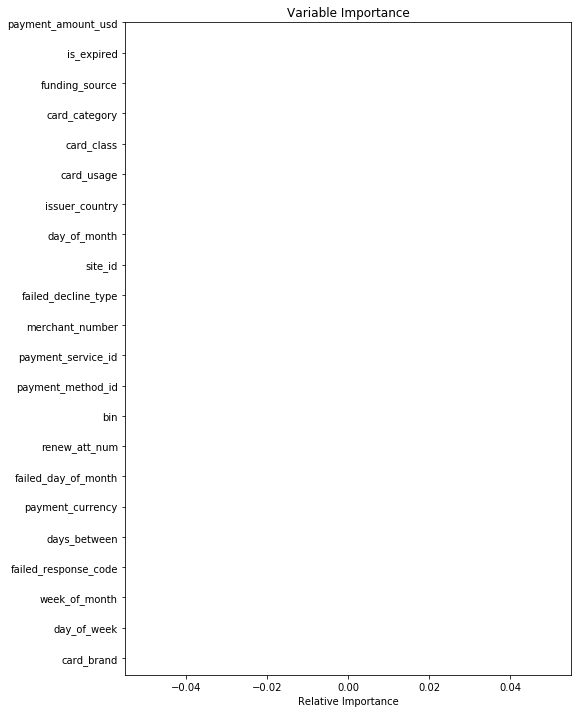

In [19]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
from src.web.preprocessing import PreProcessing
from src.web.train_util import *

# import xgboost as xgb
classifier = XGBClassifier

tuned_parameters = {
              'objective':['binary:logistic'],
              'learning_rate': [0.2], #so called `eta` value
              'max_depth': [10],
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.5],
              'colsample_bytree': [0.7],
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': [1000], #number of trees, change it to 1000 for better results  
              'missing':[-999],
              'max_delta_step':[1],  
              'seed': [1337]}

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.15, #so called `eta` value
              'max_depth': 8,
              'min_child_weight': 8,
              'silent': 0,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
#               'n_estimators': [500, 1000], #number of trees, change it to 1000 for better results
              'n_estimators': 1000, #number of trees, change it to 1000 for better results  
              'missing':-999,
              'seed': 1337,
              'gamma': 1  }

model_file = ''
model_id = 'ML-BR-1'
version = get_latest_version(model_id, MODEL_TYPE) + 1
model_name = model_id + '.' + str(version)
features_dict['eval_metric'] = 'map'
xgb_clf, result_d = build_and_train(retry_success[:100], classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters, features_dict=features_dict)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [21]:
result_d

{'hyper_params': {'objective': 'binary:logistic',
  'learning_rate': 0.15,
  'max_depth': 8,
  'min_child_weight': 8,
  'silent': 0,
  'subsample': 0.7,
  'colsample_bytree': 0.7,
  'n_estimators': 1000,
  'missing': -999,
  'seed': 1337,
  'gamma': 1},
 'training_time': 3.7105681896209717,
 'accuracy_dummy': 0.9,
 'train_accuracy': 0.8777777777777778,
 'test_accuracy': 0.9,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       0.88      1.00      0.93        79\n          1       0.00      0.00      0.00        11\n\navg / total       0.77      0.88      0.82        90\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.90      1.00      0.95         9\n          1       0.00      0.00      0.00         1\n\navg / total       0.81      0.90      0.85        10\n',
 'feature_importance_columns': "Index(['card_brand', 'day_of_week', 'week_of_month', 'failed_response_code',\n       'days_betwee

In [ ]:
# """Upload model to Nexus repo and insert the model info into Cassandra table"""
# import json

# start_date = '2018-01-01'

# end_date = '2019-05-31'

# try:
#     repo_path = upload_artifact(model_file_name)
#     preprocess_repo_path = handle_preprocessing_file(model_id, version)
#     size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
#     desc = '{}_{}_for_calendar retry model. {}'.format(start_date, end_date, size_desc)
#     hyper_params = result_d.pop('hyper_params', None)
#     extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
#     insert_model_info(model_id, version, repo_path, desc=desc, model_type=MODEL_TYPE,eval_metrics=json.dumps(result_d), 
#                       hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att), features_dict=features_dict)
    
# except:
#     if not hyper_params:
#         result_d['hyper_params'] = hyper_params 